# Purpose

2021-10-01
I now have a VM with multiple GPUs, but tensorflow only uses one GPU by default. In this notebook I'll test using dask to parallelize using multiple GPUs.

I first tried passing pre-loaded models and dataframes to the dag, but I ran into pickling errors. I might need to start using dask a few steps earlier into:
- READING THE DF
- reading the model for each df
- processing the df (inference on the whole file) 
- saving the df outputs

---

# Debugging notes

## Sometimes the best fix is `sudo reboot`
When in doubt, open a terminal and do `sudo reboot`.

For some reason, the NVIDIA drivers might not be loaded properly after shutting down a VM instance from the GUI:
- https://console.cloud.google.com/ai-platform/notebooks/list/instances?project=data-prod-165221


# Imports & notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import gc
import os
# Set logging higher BEFORE import TF
#   For some reason, this was broken in TF 2.3.4
#   https://github.com/tensorflow/tensorflow/issues/37649#issuecomment-599796966
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from pprint import pprint
from pkg_resources import get_distribution

import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
from tqdm import tqdm

import dask
from dask.distributed import Client, LocalCluster

import subclu
from subclu.utils.eda import (
    setup_logging, notebook_display_config, print_lib_versions,
)

from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.data.data_loaders import LoadSubreddits, LoadPosts, LoadComments
from subclu.models.vectorize_text_tf import (
    get_embeddings_as_df,
    save_embeddings_as_df_delayed
)


print_lib_versions([dask, np, pd, tf, tensorflow_text, subclu])

python		v 3.7.10
===
dask		v: 2021.06.0
numpy		v: 1.19.5
pandas		v: 1.3.3
tensorflow	v: 2.3.4
tensorflow_text	v: 2.3.0
subclu		v: 0.4.0


In [3]:
setup_logging()

# Check GPUs/XLA_GPUs recognized by Tensorflow/python

NOTE: `GPU`s and `XLA_GPU`s are recognized as two different device types.

https://www.tensorflow.org/xla
> **XLA: Optimizing Compiler for Machine Learning**
> XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.
> 
> The results are improvements in speed and memory usage: e.g. in BERT MLPerf submission using 8 Volta V100 GPUs using XLA has achieved a ~7x performance improvement and ~5x batch size improvement

Other sources
- https://stackoverflow.com/questions/52943489/what-is-xla-gpu-and-xla-cpu-for-tensorflow


## List devices

Expected GPU output
```
Built with CUDA? True

GPUs
===
Num GPUs Available: 2
GPU details:
[   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
    PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

Built with CUDA? True

```

In [4]:
l_phys_gpus = (
    tf.config.list_physical_devices('GPU')  # + tf.config.list_physical_devices('XLA_GPU')
)

print(
    f"\nBuilt with CUDA? {tf.test.is_built_with_cuda()}"
    f"\n\nGPUs\n==="
    f"\nNum GPUs Available: {len(l_phys_gpus)}"
    f"\nGPU details:"
)
pprint(l_phys_gpus, indent=4,)


Built with CUDA? True

GPUs
===
Num GPUs Available: 4
GPU details:
[   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
    PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
    PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
    PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


# Load config to test inference on a small batch

Also use this to make sure that we have access to the i18n bucket

In [5]:
config_data_v040 = LoadHydraConfig(
    config_path="../config/data_text_and_metadata",
    config_name='v0.4.0_19k_top_subs_and_geo_relevant_2021_09_27',
)

In [6]:
config_data_v040.config_dict

{'dataset_name': 'v0.4.0 inputs - Top Subreddits (no Geo) + Geo-relevant subs, comments: TBD',
 'bucket_name': 'i18n-subreddit-clustering',
 'folder_subreddits_text_and_meta': 'subreddits/top/2021-09-24',
 'folder_posts_text_and_meta': 'posts/top/2021-09-27',
 'folder_comments_text_and_meta': None}

## Load subreddit meta

In [7]:
%%time

df_sub_meta = LoadSubreddits(
    bucket_name=config_data_v040.config_dict['bucket_name'],
    folder_path=config_data_v040.config_dict['folder_subreddits_text_and_meta'],
    folder_posts=None,
    columns=None,
).read_raw()

22:10:03 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24"


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 178 ms, sys: 123 ms, total: 300 ms
Wall time: 448 ms


In [8]:
df_sub_meta.shape

(19262, 36)

In [9]:
# df_sub_meta['subreddit_name_title_and_clean_descriptions'].head(10).str[:100].values

# Try `dask.delayed()` example first
- https://docs.dask.org/en/latest/delayed.html

In [10]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

In [11]:
output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

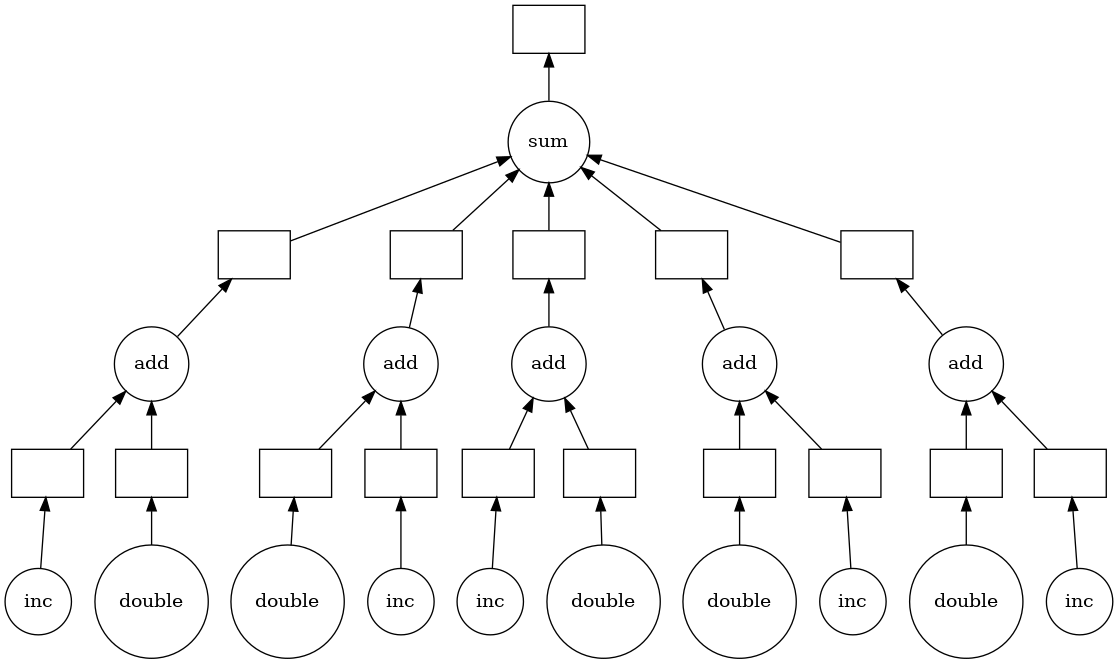

In [12]:
total.visualize()

In [13]:
%%time
total.compute()

CPU times: user 135 ms, sys: 25.8 ms, total: 161 ms
Wall time: 159 ms


50

In [15]:
total_computed = total.compute()

In [16]:
total_computed

50

# Test new parallel function

I was running into pickling problems when I tried passing dataframes and models already loaded into memory.

So this new parallel function expects as input strings (paths) instead of dataframes or models that are pre-loaded - it means each thread should be able to run independently and all the data should be pickle-able.

Updated / New params:

| Parameter  | Old input  | New input  | Notes  |
|---|---|---|:---|
| model | pre-loaded model  | path to model  | each thread will load its own model |
| df -> load hydra config params | pre-loaded pandas df  | path to specific df  | Each thread should load its own DF so that way we prevent pickling errors and also speed up by reading multiple files at the same time  |
| name of data loader fxn | n/a | name (string) of data loader | We want it to be the name/string instead of the data class to prevent pickling errors |
|  |  |  |  |

## Initialize dask workers & cluster

Note that the worker commands should be run in a terminal outside of jupyter (maybe in tmux to reduce number of open terminals)

In [ ]:
# CUDA_VISIBLE_DEVICES=0 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# CUDA_VISIBLE_DEVICES=1 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# CUDA_VISIBLE_DEVICES=2 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# CUDA_VISIBLE_DEVICES=3 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1

In [ ]:
# CUDA_VISIBLE_DEVICES=0 dask-worker 127.0.0.1:8786 --nprocs=1 --nthreads=1 --memory-limit="22 GiB"
# CUDA_VISIBLE_DEVICES=1 dask-worker 127.0.0.1:8786 --nprocs=1 --nthreads=1 --memory-limit="22 GiB"
# CUDA_VISIBLE_DEVICES=2 dask-worker 127.0.0.1:8786 --nprocs=1 --nthreads=1 --memory-limit="22 GiB"
# CUDA_VISIBLE_DEVICES=3 dask-worker 127.0.0.1:8786 --nprocs=1 --nthreads=1 --memory-limit="22 GiB"

In [30]:
cluster = LocalCluster(n_workers=0, scheduler_port=8786) # dask sets the default to 8 workers with 64 CPUs present
client = Client(cluster)  # 'scheduler:8786'

19:20:57 | WARNING | "Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly"
19:20:57 | INFO | "Keep-alive ping configured every 500 milliseconds"
19:20:57 | INFO | "Check for unused sessions every 500 milliseconds"
19:20:57 | INFO | "User authentication hooks NOT provided (default user enabled)"
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:      tcp://127.0.0.1:8786
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787
distributed.scheduler - INFO - Receive client connection: Client-b495a30c-22ec-11ec-bd7c-42010a8a0003
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:45157', name: tcp://127.0.0.1:45157, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:45157
distributed.core - I

### Check status of dask cluster

Open reverse proxy:<br>`
dj_dask_ssh gpu4`

Go to: <br>
http://127.0.0.1:8787/workers
    
    
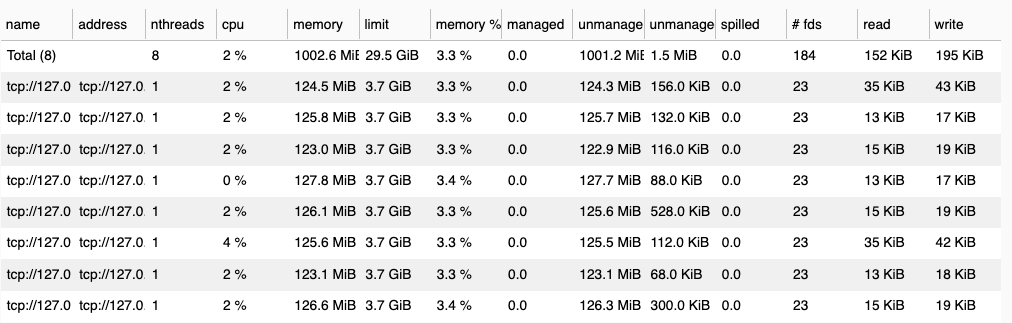

## Define dask DAG

In [21]:
p_local_folder = Path('/home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24')

In [22]:
[f_ for f_ in p_local_folder.glob('*')]

[PosixPath('/home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24/000000000000.parquet')]

In [23]:
f_test_file = '/home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24/000000000000.parquet'

In [24]:
path_temp_output = p_local_folder / 'temp_output'

In [25]:
%%time
df_test_ = pd.read_parquet(f_test_file)
df_test_.shape

CPU times: user 99.7 ms, sys: 154 ms, total: 254 ms
Wall time: 176 ms


(19262, 36)

In [26]:
# df_test_.head()

In [27]:
# l_parallel_outputs = list()
# for f_ in ([f_test_file] * 4):
#     l_parallel_outputs.append(
#         save_embeddings_as_df_delayed(
#             model_url="https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
#             df_file=f_,
#             output_folder=path_temp_output,
#             lowercase_text=False,
#             batch_size=2000,
#             limit_first_n_chars=1000,
#             log_to_mlflow=False,
#         )
#     )
# df_outputs_delayed = dask.delayed(pd.DataFrame)(l_parallel_outputs)

In [28]:
# df_outputs_delayed.visualize()

```
TypeError                                 Traceback (most recent call last)
/tmp/ipykernel_32124/2862017137.py in <module>
----> 1 df_outputs_delayed.compute()

home/david.bermejo/repos/subreddit_clustering_i18n/subclu/models/vectorize_text_tf.py in save_embeddings_as_df_delayed()
    609 ):
    610     """
--> 611     Wrapper with dask-delayed around get_embeddings_as_df
    612 
    613     Args:

TypeError: 'module' object is not callable

```

In [54]:
# df_outputs_delayed.compute()

### try w/o the function wrapper

In [42]:
def load_use_model(model_url):
    """Load model so we can use it in dask delayed, each worker should be able to load tf & tf-text
    on its own thread
    """
    import os
    # Set logging higher BEFORE import TF
    #   For some reason, this was broken in TF 2.3.4
    #   https://github.com/tensorflow/tensorflow/issues/37649#issuecomment-599796966
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    
    import tensorflow_text
    import tensorflow as tf
    import tensorflow_hub as hub
    
    return hub.load(model_url)


In [45]:
l_parallel_outputs = list()

model_url="https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
col_text = 'subreddit_name_title_and_clean_descriptions'
cols_index = 'subreddit_default_'
col_embeddings_prefix = 'embeddings'
lowercase_text = False
batch_size = 2000
limit_first_n_chars = 850


for f_ in ([f_test_file] * 4):
    import tensorflow_text
    import tensorflow_hub

    df_input = dask.delayed(pd.read_parquet)(f_)
    
    model = dask.delayed(load_use_model)(model_url)
    
    l_parallel_outputs.append(
        dask.delayed(get_embeddings_as_df)(
            model,
            df_input,
            col_text,
            cols_index,
            col_embeddings_prefix,
            lowercase_text,
            batch_size,
            limit_first_n_chars,
        )
    )

df_outputs_delayed = dask.delayed(pd.concat)(l_parallel_outputs)

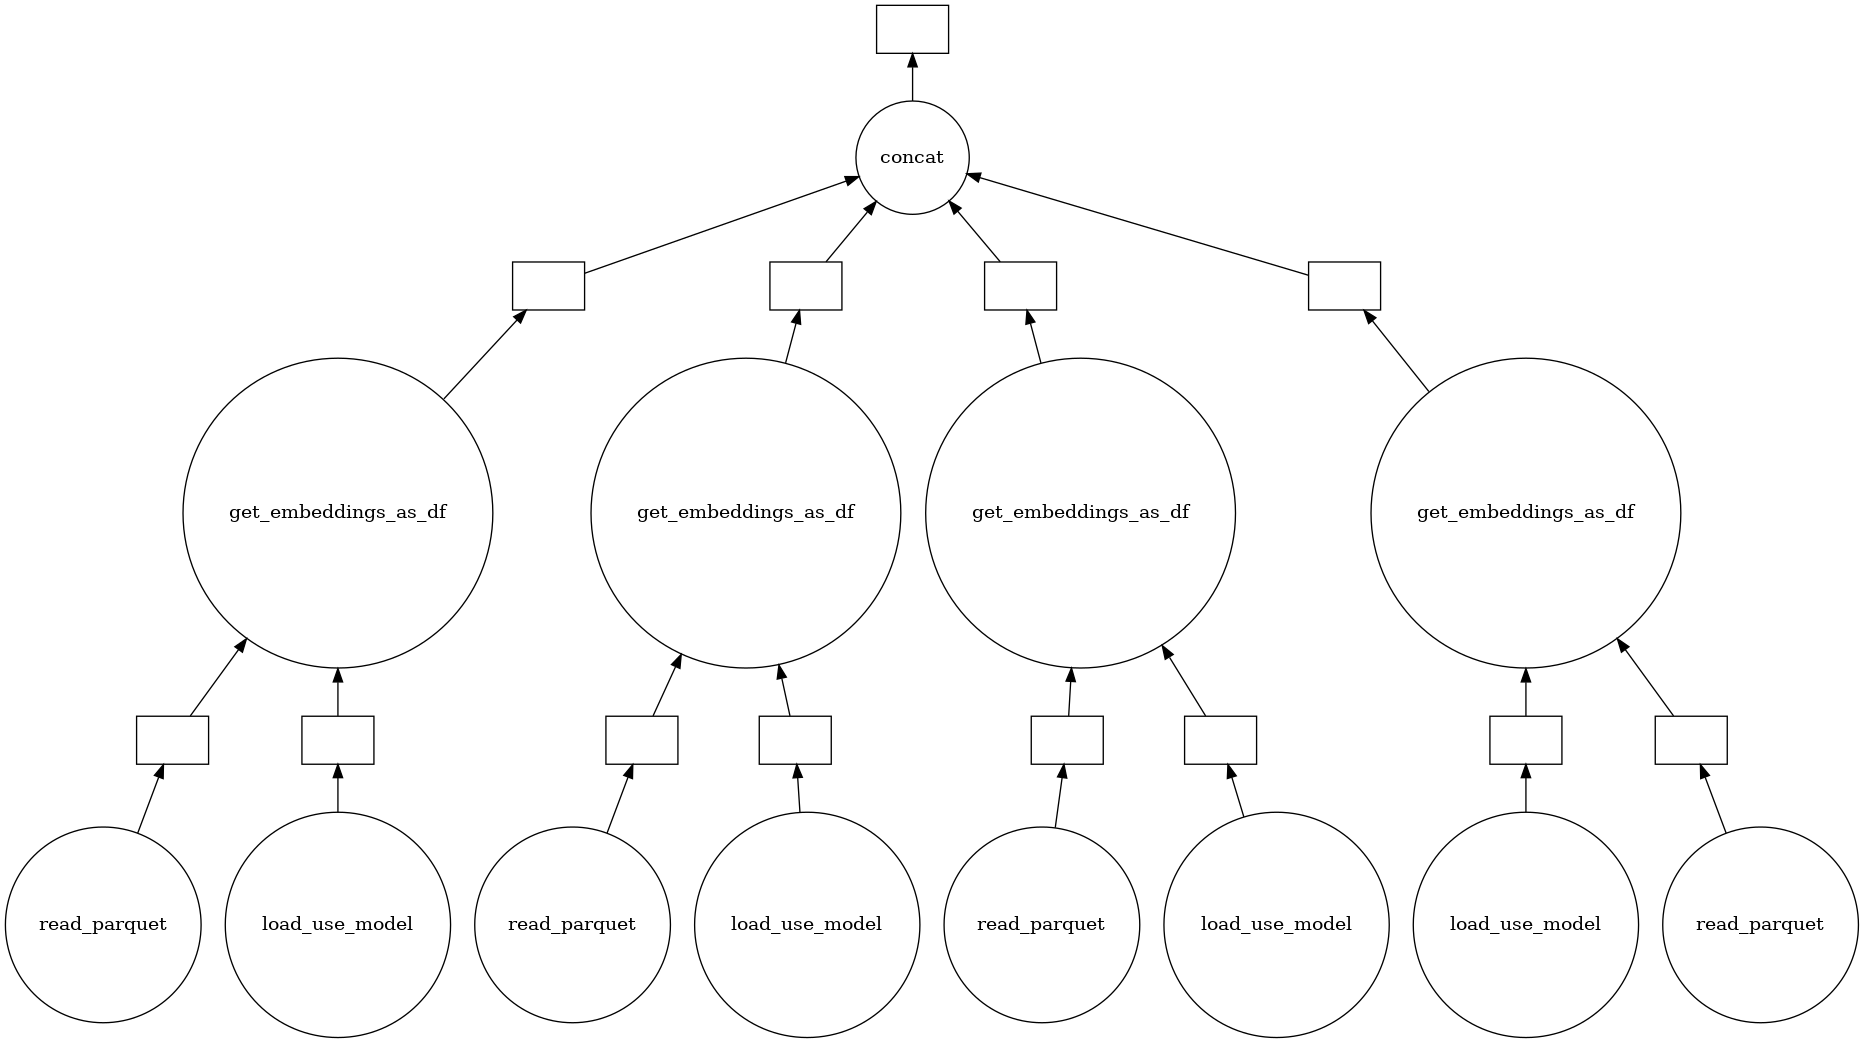

In [46]:
df_outputs_delayed.visualize()

In [ ]:
%%time

df_outputs_delayed.compute()

Things to fix:
`SentOpPiece` not found:
- had to make custom function that for each batch loads (tf, tf_text, & tf_hub), otherwise each process might not be aware of each other's functions


`dst tensor is not initialized`
???
```
InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

```


`Blas GEMM launch failed`
???
```
InternalError:  Blas GEMM launch failed : a.shape=(450823, 512), b.shape=(512, 256), m=450823, n=256, k=512
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/EncoderDNN/CNN_layers/ngram_order_2/input_size_projection/dense/MatMul}}]] [Op:__inference_restored_function_body_31749]

Function call stack:
restored_function_body
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/distributed/core.py", line 494, in handle_comm
    result = handler(comm, **msg)
  File "/opt/conda/lib/python3.7/site-packages/distributed/scheduler.py", line 3885, in heartbeat_worker
    parent._tasks[key]: duration for key, duration in executing.items()
  File "/opt/conda/lib/python3.7/site-packages/distributed/scheduler.py", line 3885, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: 'load_use_model-10c6a0fe-5717-4a25-ad85-d6fa7cc1bd3b'
```


In [91]:
# get & set config for logging to get better debugging metrics
import dask.config

In [96]:
# dask.config.config

In [95]:
dask.config.set({'logging.loggers.distributed.worker.level': logging.INFO})

In [99]:
# dask.config.config

In [89]:
import logging
logging.info(f"check logging")

21:40:28 | INFO | "check logging"


In [ ]:
LEGACY

### Load USE-multilingual

NOTE: I had 2 notebooks running - the other notebook started first, and it caused an OOM (out of memory) error when trying to load the `large` version.

Remember to shut down other scripts/notebooks!
```
2021-10-01 02:29:43.934252: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.71MiB (rounded to 15421440)requested by op Identity
...
```

In [12]:
# %%time
# use_multi_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

CPU times: user 7.87 s, sys: 1.79 s, total: 9.67 s
Wall time: 8.9 s


In [51]:
# %%time
# use_multi = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

CPU times: user 2.4 s, sys: 531 ms, total: 2.93 s
Wall time: 2.59 s


In [8]:
# del use_multi_large

In [9]:
gc.collect()

2503

# Options for running in parallel

Above tests weren't great... seems like TF will only use one core at a time for GPU inference........ UGH
- This issue was opened in 2017 (and is still open w/o a solution)
    - https://github.com/tensorflow/serving/issues/311 
    
    
### Multiprocessing
So I would need to write custom code to manually split up the chunks and run the multi-process myself. This AWS blog post from 2 years ago provides a way to do it... but it might take some thinking to refactor.
- blog post
    - https://aws.amazon.com/blogs/machine-learning/parallelizing-across-multiple-cpu-gpus-to-speed-up-deep-learning-inference-at-the-edge/
- github repo
    - https://github.com/aws-samples/parallelize-ml-inference

### Use `dask.delayed()` instead of multiprocessing?
My mental model if `dask.delayed()` is better than `multiprocessing`, so maybe that's worth a shot?

### Spark?
- https://datasciencevademecum.com/2020/05/21/embedding-billions-of-text-documents-using-tensorflow-universal-sentence-encoder-on-top-of-spark-emr/https://datasciencevademecum.com/2020/05/21/embedding-billions-of-text-documents-using-tensorflow-universal-sentence-encoder-on-top-of-spark-emr/

### Manual Batching
This one seems to use TF sessions (those might be deprecated, though).
- https://medium.com/@sbp3624/tensorflow-multi-gpu-for-inferencing-test-time-58e952a2ed95

In [46]:
%%time

df_embeddings = get_embeddings_as_df(
    model=use_multi,
    df=df_sub_meta,
    col_text='subreddit_name_title_and_clean_descriptions',
    cols_index='subreddit_default_',
    limit_first_n_chars=1000,
    batch_size=2200,
)

05:50:26 | INFO | "Getting embeddings in batches of size: 2200"
  0%|                                                     | 0/9 [00:00<?, ?it/s]05:50:36 | WARNING | "
ResourceExhausted, lowering character limit
 OOM when allocating tensor with shape[573337,1280] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/EncoderDNN/CNN_layers/ngram_order_5/Ngram-5-Conv/concat_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_restored_function_body_66405]

Function call stack:
restored_function_body

"
100%|#############################################| 9/9 [00:23<00:00,  2.58s/it]

CPU times: user 17.3 s, sys: 265 ms, total: 17.6 s
Wall time: 23.6 s


# Try `dask.delayed()`

## Run the embeddings on all 4 GPUs at the same time

Let's run the same text on all 4 GPUs. If they run in parallel, we should see the run time about the same as running the text 1 time in one GPU.

Note that we might have some more overhead b/c we'll need to load the model in each GPU.

In [33]:
l_gpu_names = [gpu_.name.replace('physical_device:', '') for gpu_ in tf.config.list_physical_devices('GPU')]
l_gpu_names

['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3']

In [15]:
# %%time
# l_gpu_models = list()
# for gpu_ in l_gpu_names:
#     with tf.device(gpu_):
#         l_gpu_models.append(hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"))

In [34]:
l_gpu_models

[<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb625a97290>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb5c862c690>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb5b05bde50>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb5680eef50>]

In [35]:
# loop through each GPU and get inference for each model
# this no longer works.. not sure what changed? is it serializing when we have a cluster??

l_df_embeddings = list()

for i, gpu_ in enumerate(l_gpu_names):
    with tf.device(gpu_):
        l_df_embeddings.append(
            get_embeddings_as_df_delayed(
                model=l_gpu_models[i],
                df=df_sub_meta,
                col_text='subreddit_name_title_and_clean_descriptions',
                cols_index='subreddit_default_',
                limit_first_n_chars=1000,
                batch_size=2200,
            )
        )
df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

In [40]:
# df_vect_delayed.visualize()

This did NOT run in parallel, it was sequential on one GPU

```
...
100%|#############################################| 9/9 [02:04<00:00, 13.79s/it]
100%|#############################################| 9/9 [02:05<00:00, 13.98s/it]
100%|#############################################| 9/9 [02:04<00:00, 13.87s/it]
100%|#############################################| 9/9 [02:05<00:00, 13.98s/it]
/opt/conda/lib/python3.7/site-packages/dask/core.py:121: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return func(*(_execute_task(a, cache) for a in args))
CPU times: user 2min 4s, sys: 11.6 s, total: 2min 16s
Wall time: 2min 8s

```

In [41]:
# %%time

# df_vect_delayed.compute()

## Let's try again, but this time let's start a cluster & workers

- https://docs.dask.org/en/latest/gpu.html

- https://www.youtube.com/watch?v=jLQ2wAwapRg&t=894s&ab_channel=Enthought


Start workers in command line

In [ ]:
# !CUDA_VISIBLE_DEVICES=0 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# !CUDA_VISIBLE_DEVICES=1 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# !CUDA_VISIBLE_DEVICES=2 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1
# !CUDA_VISIBLE_DEVICES=3 dask-worker 127.0.0.1:8786 --nprocs=2 --nthreads=1

In [17]:
cluster = LocalCluster(n_workers=0, scheduler_port=8786) # dask sets the default to 8 workers with 64 CPUs present
client = Client(cluster)  # 'scheduler:8786'

22:11:32 | WARNING | "Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly"
22:11:32 | INFO | "Keep-alive ping configured every 500 milliseconds"
22:11:32 | INFO | "Check for unused sessions every 500 milliseconds"
22:11:32 | INFO | "User authentication hooks NOT provided (default user enabled)"
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:      tcp://127.0.0.1:8786
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:36709', name: tcp://127.0.0.1:36709, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:36709
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-88fe80e6-2304-11ec-89d8-42010a8a0003
distributed.core - I

In [18]:
# l_gpu_names = [gpu_.name.replace('physical_device:', '') for gpu_ in tf.config.list_physical_devices('GPU')]
# l_gpu_names

In [19]:
# %%time
# l_gpu_models = list()
# for gpu_ in l_gpu_names:
#     with tf.device(gpu_):
#         l_gpu_models.append(hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"))

In [20]:
# l_gpu_models

22:13:35 | INFO | "WebSocket connection opened"
22:13:35 | INFO | "ServerConnection created"
22:13:41 | INFO | "WebSocket connection closed: code=1001, reason=None"
22:13:41 | INFO | "WebSocket connection opened"
22:13:41 | INFO | "ServerConnection created"
22:13:49 | INFO | "WebSocket connection closed: code=1001, reason=None"
22:13:49 | INFO | "WebSocket connection opened"
22:13:49 | INFO | "ServerConnection created"


In [63]:
# # loop through each GPU and get inference for each model

# l_df_embeddings = list()

# for i, gpu_ in enumerate(l_gpu_names):
#     with tf.device(gpu_):
#         l_df_embeddings.append(
#             get_embeddings_as_df_delayed(
#                 model=l_gpu_models[i],
#                 df=df_sub_meta,
#                 col_text='subreddit_name_title_and_clean_descriptions',
#                 cols_index='subreddit_default_',
#                 limit_first_n_chars=1000,
#                 batch_size=2200,
#             )
#         )

# df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

In [64]:
# loop through each GPU and get inference for each model

l_df_embeddings = list()

for i, gpu_ in enumerate(l_gpu_names):
    with tf.device(gpu_):
        l_df_embeddings.append(
            dask.delayed(get_embeddings_as_df)(
                l_gpu_models[i],
                df_sub_meta.copy(),
                'subreddit_name_title_and_clean_descriptions',
                'subreddit_default_',
                'embeddings',
                False,
                1000,
                2200,
            )
        )

df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

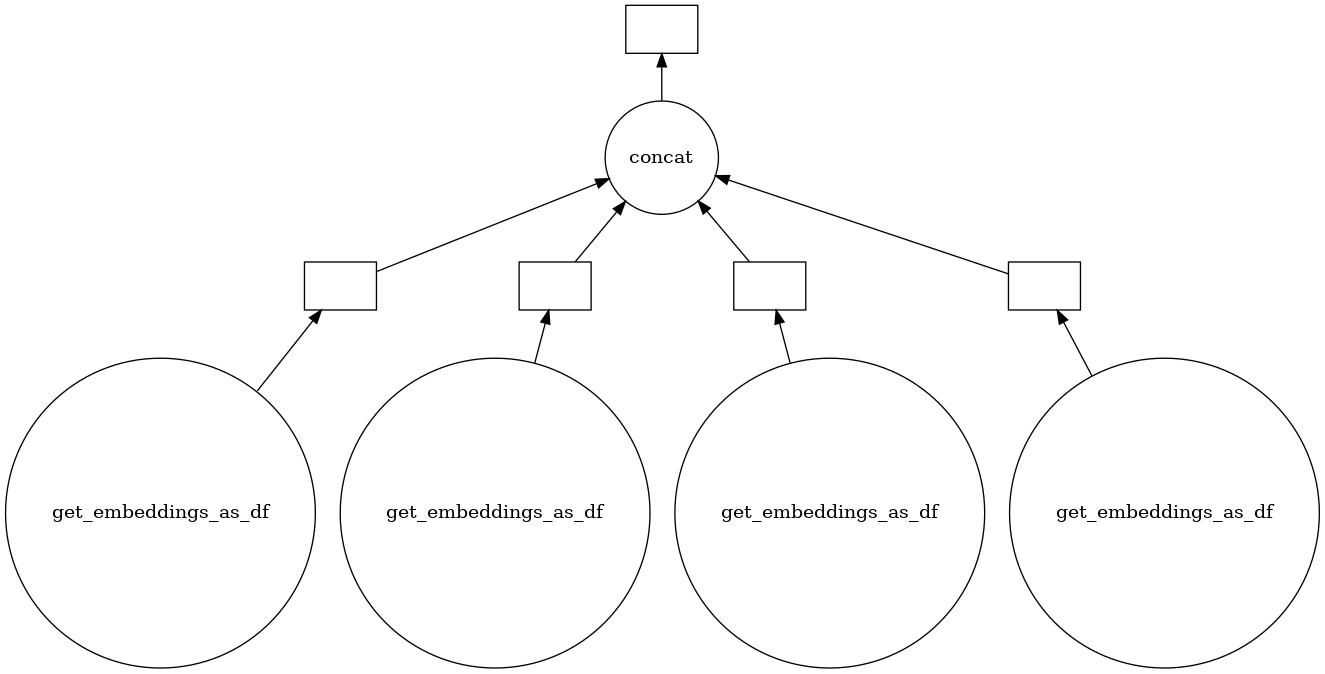

In [65]:
df_vect_delayed.visualize()

```
------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/opt/conda/lib/python3.7/site-packages/distributed/protocol/pickle.py in dumps(x, buffer_callback, protocol)
     48         buffers.clear()
---> 49         result = pickle.dumps(x, **dump_kwargs)
     50         if len(result) < 1000:

AttributeError: Can't pickle local object 'Loader._recreate_base_user_object.<locals>._UserObject'

During handling of the above exception, another exception occurred:

PickleError                               Traceback (most recent call last)
/tmp/ipykernel_12880/435696660.py in <module>
----> 1 df_vect_delayed.compute()

/opt/conda/lib/python3.7/site-packages/dask/base.py in compute(self, **kwargs)
    283         dask.base.compute
    284         """
--> 285         (result,) = compute(self, traverse=False, **kwargs)
    286         return result
    287 

```

In [68]:
# df_vect_delayed.compute()

In [56]:
# loop through each GPU and get inference for each model

l_df_embeddings = list()

for i, gpu_ in enumerate(l_gpu_names):
    with tf.device(gpu_):
        l_df_embeddings.append(
            dask.delayed(get_embeddings_as_df)(
                use_multi,
                df_sub_meta.copy(),
                # 'subreddit_name_title_and_clean_descriptions',
                # 'subreddit_default_',
                # 'embeddings',
                # False,
                # 1000,
                # 2200,
            )
        )

df_vect_delayed = dask.delayed(pd.concat)(l_df_embeddings, 0, 'outer', False)

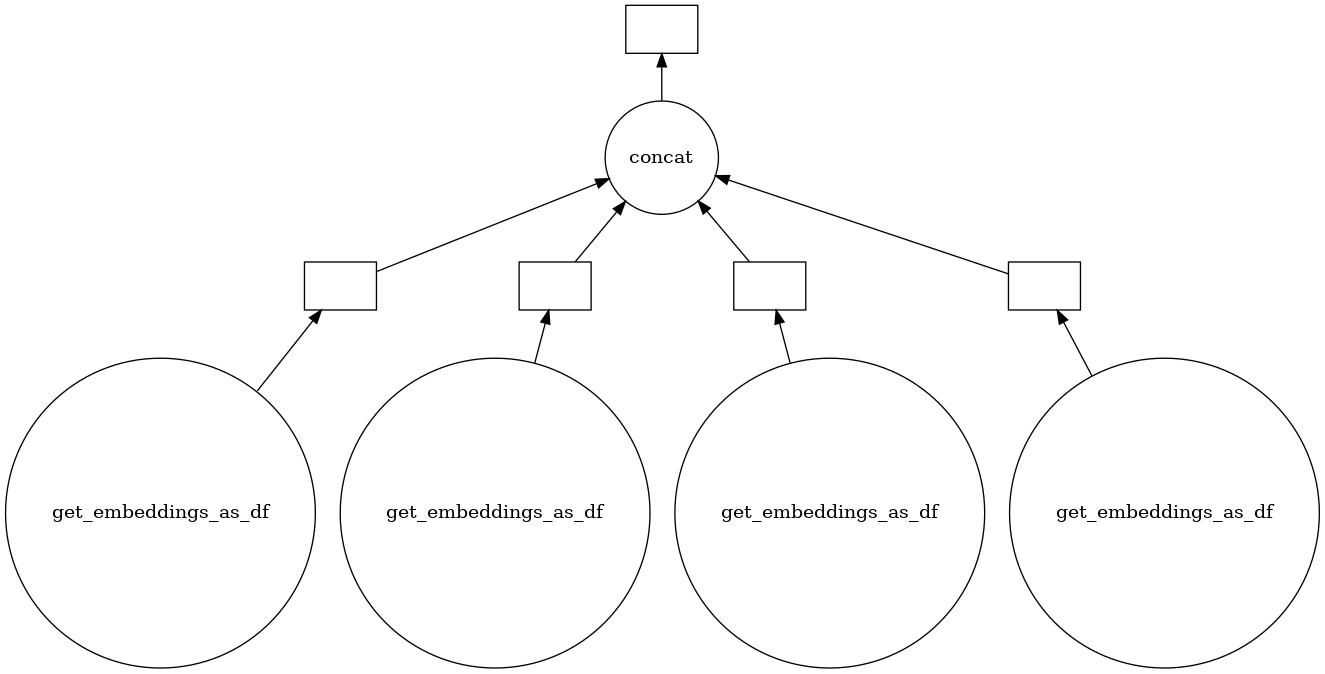

In [57]:
df_vect_delayed.visualize()

In [69]:
# df_vect_delayed.compute()

In [70]:
# # close or restart client & cluster
client.close()
cluster.close()

# cluster.restart()
# client.restart()